In [1]:
import json
import jax
import jax.numpy as jnp
import jax.random as jrandom

# Some small helper functions
from probjax.distributions.discrete import Empirical
from probjax.distributions.independent import Independent
from probjax.distributions.sde import VESDE
from train_interface.data_handling import random_nan, normalize_data, normalize_with_params
from train_interface.Visualize import plot_pairplot_comparison_points

from train_interface.build_transfomer_model import BuildTransformerModel
from train_interface.wrapper import SimFormer
from train_interface.config_class import TrainingConfig, SDEConfig, SimformerConfig, TransformerConfig, DiffusionConfig, set_config_values

# Check CUDA support
jax.devices()  # Should be cuda
# Set random key
key = jax.random.PRNGKey(5)

ImportError: cannot import name 'JaxprEqn' from 'jax.core' (/Users/ratzenboe/Documents/work/projects/AstroSimformer/venv1/lib/python3.10/site-packages/jax/core.py)

### 1) Data Generation


## Data Generation Functions

### **Theta Generation**
- $\theta_1 \sim \mathcal{N}(0, 3)$
- $\theta_2 \sim \mathcal{N}(0, 2)$

---

### **Data Features Calculation**
- **$x_1$** = $2 \cdot \sin(\theta_1) + 3 \cdot \cos(\theta_2) + \mathcal{N}(0, 0.5)$
- **$x_2$** = $0.1 \cdot \theta_1^2 + 0.5 \cdot |x_1| \cdot \mathcal{N}(0, 1)$
- **$x_3$** = $0.5 \cdot \theta_2 + 0.2 \cdot |x_2| \cdot \mathcal{N}(0, 1)$


In [8]:
# this switch is to indicate if you want to work with the csv file or just simulated example data
error = 0.5
def generate_data_combined_normal(key: jrandom.PRNGKey, n: int):
    key1, key2, key3, key4, key5 = jrandom.split(key, 5)
    theta1 = jrandom.normal(key1, (n, 1)) * 3
    theta2 = jrandom.normal(key4, (n, 1)) * 2

    x1 = 2 * jnp.sin(theta1) + 3 * jnp.cos(theta2) + jrandom.normal(key2, (n, 1)) * 0.5
    x2 = 0.1 * theta1**2 + 0.5 * jnp.abs(x1) * jrandom.normal(key3, (n, 1))
    x3 = 0.5 * theta2 + 0.2 * jnp.abs(x2) * jrandom.normal(key5, (n, 1))

    data = jnp.concatenate([theta1, theta2, x1, x2, x3], axis=1).reshape(n, -1, 1)
    data_with_nans = random_nan(data, key, error)

    # Normalize data
    normalized_data, means, stds = normalize_data(data_with_nans)
    data_norm = normalize_with_params(data, means, stds)

    return normalized_data, data_norm, data_with_nans, data, means, stds

# 2 Create Data for all tries

This just creates the data using the functions above

In [10]:
# important here amount of data does it change something ?
data, data_clean, data_no_norm, data_clean_no_norm, means, stds = generate_data_combined_normal(
    jrandom.PRNGKey(1), 2**13
)  # Shape: (n, nodes, dim) here dim = 1
# nodes max = how many data points
nodes_max = data_clean.shape[1]
# creates id for notes ?
node_ids = jnp.arange(nodes_max)
print(data.shape)
# check if nan values are present
print(jnp.isnan(data).sum())
n_features = data.shape[1]
labels = [f"x{i+1}" for i in range(n_features)]  # Automatically generate labels

(8192, 5, 1)
20480


# 3) Config part
This could be done much more smoothly, but I am too lazy to change that right now

In [11]:
# Initialize the dataclasses with zero or default values
sde_config = SDEConfig()
simformer_config = SimformerConfig()
transformer_config = TransformerConfig()
training_config = TrainingConfig()
diffusion_config = DiffusionConfig()

# Define values to set for each config parameter for multiple configurations
with open('simformer_config.json', 'r') as f:
    config_set = json.load(f)

set_config_values(sde_config, config_set["SDEConfig"])
set_config_values(simformer_config, config_set["SimformerConfig"])
set_config_values(transformer_config, config_set["TransformerConfig"])
set_config_values(training_config, config_set["TrainingConfig"])
set_config_values(diffusion_config, config_set["DiffusionConfig"])

T = sde_config.T
T_min = sde_config.T_min
sigma_min = sde_config.sigma_min
sigma_max = sde_config.sigma_max

dim_value = simformer_config.dim_value
dim_id = simformer_config.dim_id
dim_condition = simformer_config.dim_condition

num_heads = transformer_config.num_heads
num_layers = transformer_config.num_layers
attn_size = transformer_config.attn_size
widening_factor = transformer_config.widening_factor

epochs = training_config.epochs
time_steps = diffusion_config.time_steps

# Print or run the experiment for the current configuration
print(f"SDEConfig: {sde_config}")
print(f"SimformerConfig: {simformer_config}")
print(f"TransformerConfig: {transformer_config}")
print(f"TrainingConfig: {training_config}")
print(f"DiffusionConfig: {diffusion_config}")
print("---" * 20)

SDEConfig: SDEConfig(T=1.0, T_min=0.01, sigma_min=0.001, sigma_max=15.0)
SimformerConfig: SimformerConfig(dim_value=20, dim_id=20, dim_condition=10)
TransformerConfig: TransformerConfig(num_heads=2, num_layers=3, attn_size=30, widening_factor=3)
TrainingConfig: TrainingConfig(epochs=1000)
DiffusionConfig: DiffusionConfig(time_steps=512)
------------------------------------------------------------


# 4) Main Part of the Simformer

In [12]:
# This creates the SDE for noise in diffusion model
data_clean = data.copy()
# impute NaNs with 0 -> this is done for because "Independent" cannot handle NaNs
# but these values will be masked during training so it will not affect the learning
data_clean = jnp.nan_to_num(data_clean, 0.0)

p0 = Independent(Empirical(data_clean), 1)
# Set up the diffusion part, here variance exploding SDE
sde = VESDE(p0, sigma_min=sigma_min, sigma_max=sigma_max)
# Set up transfomer model
tm = BuildTransformerModel(sde, nodes_max, dim_value, dim_id, dim_condition, num_heads, num_layers, attn_size, widening_factor)
init, model_fn = tm()

In [13]:
# Bring parameters in such a form that the model can use them
params = init(key, jnp.ones(data.shape[0]), data, node_ids, jnp.zeros_like(node_ids))
# Here we can see the total number of parameters and their shapes
print("Total number of parameters: ", jax.tree_util.tree_reduce(lambda x,y: x+y, jax.tree_map(lambda x: x.size, params)))
jax.tree_util.tree_map(lambda x: x.shape, params) # Here we can see the shapes of the parameters

# Wrapper class that handles training class
# TODO: refactored at some point to also set up the sde and tranformer model -> no real reason to separate them
tsm = SimFormer(
    time_steps=time_steps,
    key=key, data=data, sde=sde, model_fn=model_fn, params=params, T_min=T_min,
    nodes_max=nodes_max, batch_size=1024,
    lr=1e-3, inner_train_loop_size=200, early_stopping_patience=20,
    model_check_point_dir='model_checkpoint'
)

Total number of parameters:  102566


In [7]:
model_path_name = None
# Check if a model path is provided
if model_path_name is not None:
    tsm.load_best_model(model_path_name)
else:
    print("No model saved, fitting anew")
    tsm.fit(epochs=100)

Best parameters loaded from model_checkpoint/toy5D.pkl


In [9]:
ys = tsm.sample_fn(
    jrandom.PRNGKey(0), (1_000,), condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,))
)
samples = (ys[:,-1,:] * stds) + means

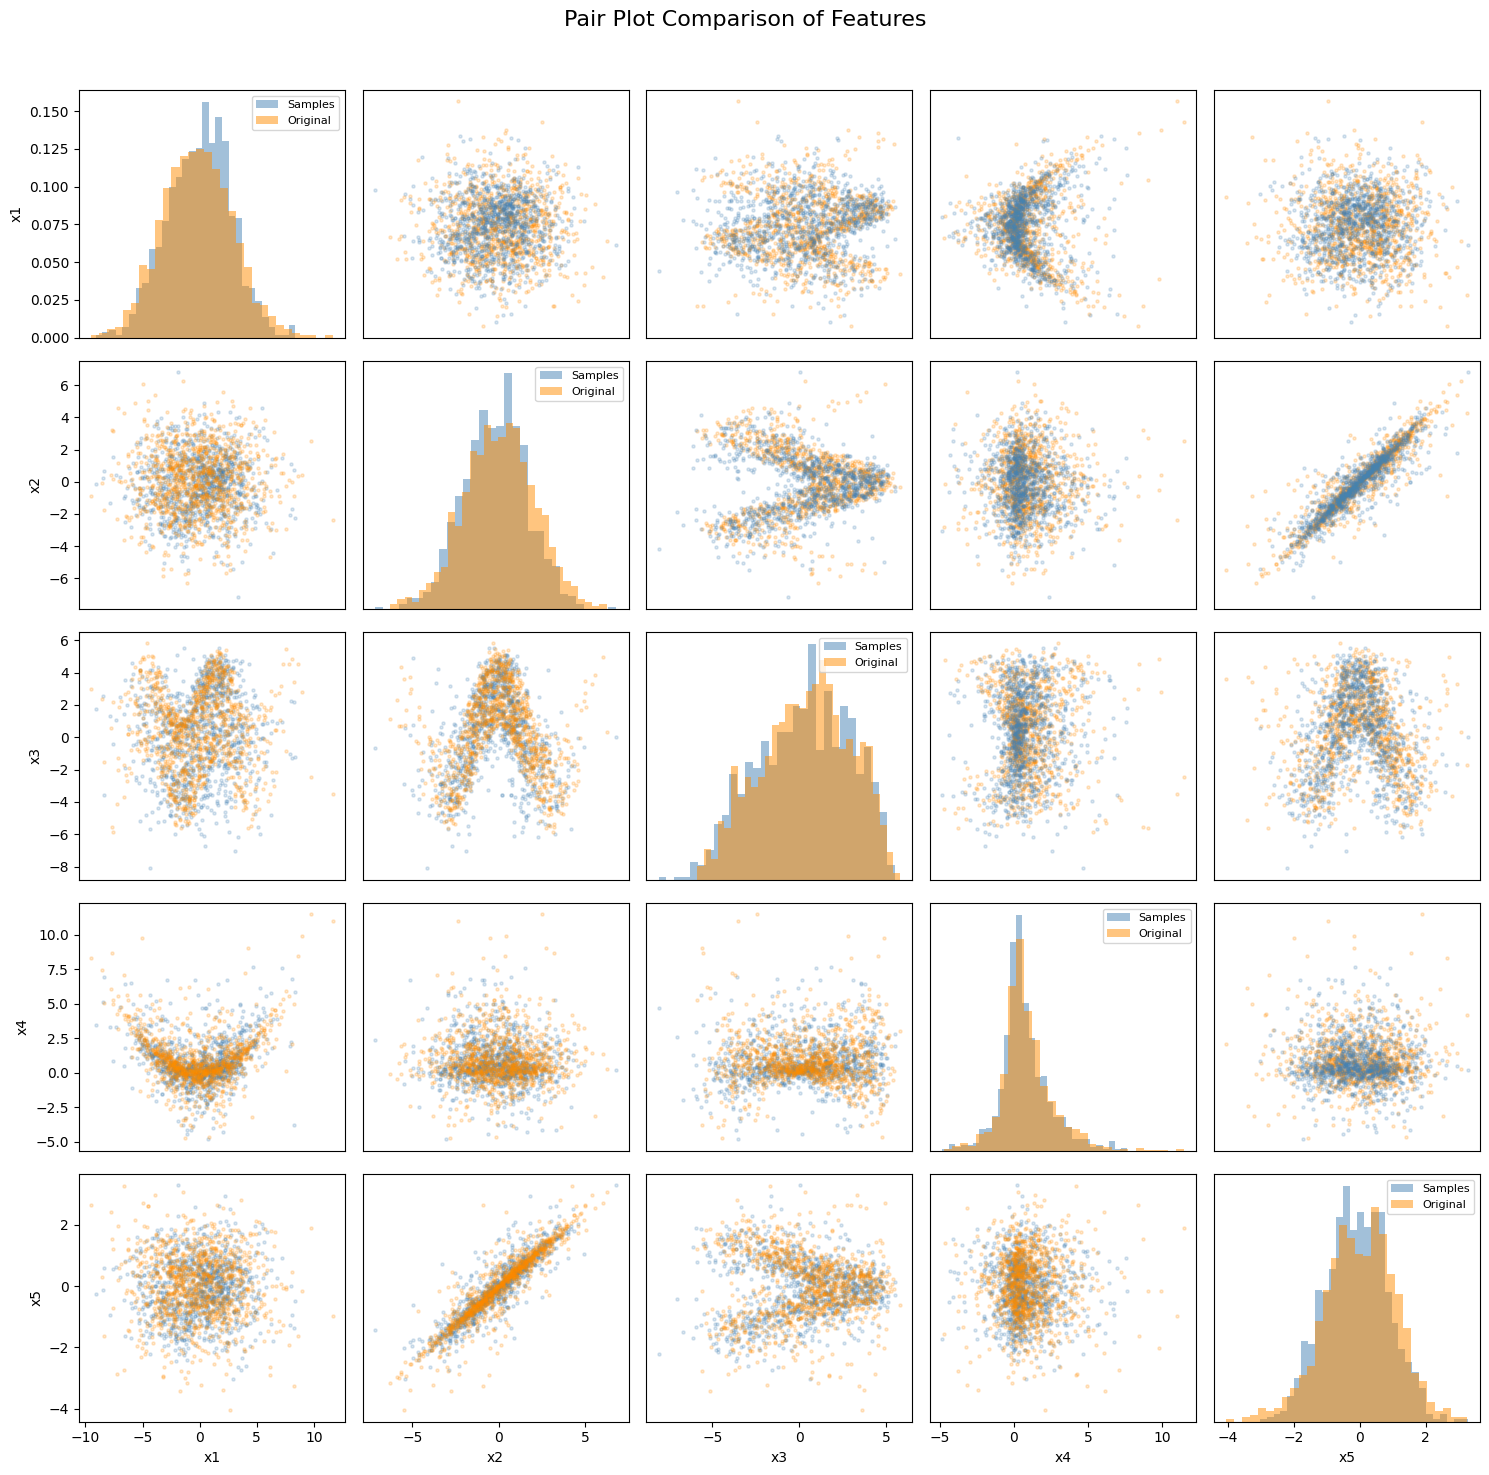

In [10]:
# Full joint estimation
# Taking samples and visualizing them (after some formation)
samples_new = samples
data_new = data_clean_no_norm[:, :, -1][:1_000]
plot_pairplot_comparison_points(samples_new, data_new, labels, dataset_labels=('Samples', 'Original'))
# plot_pairplot_comp_kde2(samples_new, data_new, labels)